# 0. Import Modules

In [1]:
from ultralytics import YOLO
import cv2
import os
import numpy as np
import torch
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import patches
from glob import glob
from tqdm import tqdm
from collections import defaultdict
from ultralytics import YOLO
from deep_sort.deep_sort import DeepSort

## 0.1 Initialization

In [2]:
# 初始化检测模型与 Deep SORT
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = YOLO('yolo11m.pt')
deep_sort = DeepSort(model_path="deep_sort/deep/checkpoint/ckpt_.t7")

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [91]:
video_id = 1

In [92]:
video_path = os.path.join('videos', str(video_id).zfill(3), 'input.webm')
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()
print(f"Video FPS: {fps}")

Video FPS: 30.060120240480963


In [5]:
def format_timestamp(frame_idx, fps):
    total_ms = int(round(frame_idx * 1000 / fps))
    hours = total_ms // 3600000
    minutes = (total_ms % 3600000) // 60000
    seconds = (total_ms % 60000) // 1000
    ms = total_ms % 1000
    return f"{hours:d}:{minutes:02d}:{seconds:02d}.{ms:03d}"

# 1. Build Dataset

## 1.1 Extract Frames

In [6]:
def extract_frames_from_video(video_path, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_path = os.path.join(save_dir, f"{str(frame_idx).zfill(5)}.jpg")
        cv2.imwrite(frame_path, frame)
        frame_idx += 1
    cap.release()
    print(f"Extracted {frame_idx} frames from {video_path} to {save_dir}")

## 1.2 Detect and Save Boxes

In [68]:
def detect_and_save_boxes(video_id, data_root='./videos', save_dir='./boxes', threshold=0.5):
  try:
    data_dir = os.path.join(data_root, str(video_id).zfill(3))
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"视频帧目录 {data_dir} 不存在")

    imgs = sorted(glob(os.path.join(data_dir, '*.jpg')))
    if len(imgs) == 0:
        print(f"Warning: 目录 {data_dir} 中未找到任何图像")
        return

    save_path = os.path.join(save_dir, f"{video_id}.npy")
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    frame_boxes = []

    for img_path in tqdm(imgs, desc=f"检测视频 {video_id}"):
      img_bgr = cv2.imread(img_path)
      img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

      # YOLO推理
      results = model.predict(img_rgb, imgsz=640, conf=threshold, verbose=False)[0]

      if results.boxes is None or len(results.boxes) == 0:
          boxes = []
      else:
          boxes = results.boxes.xyxy.cpu().numpy()
          scores = results.boxes.conf.cpu().numpy()
          boxes = [box for box, score in zip(boxes, scores) if score >= threshold]

      if len(boxes) == 0:
          frame_boxes.append(np.zeros((0, 4), dtype=np.float32))
      else:
          frame_boxes.append(np.array(boxes, dtype=np.float32))


    np.save(save_path, np.array(frame_boxes, dtype=object))
    print(f"检测完成，保存至 {save_path}")

  except Exception as e:
        print(f"检测失败：{e}")

## 1.3 Visualize Boxes

In [8]:
def visualize_detection(video_id, frame_idx, box_dir="./boxes", frame_dir_root="./videos"):
    frame_dir = os.path.join(frame_dir_root, str(video_id).zfill(3))
    img_path = os.path.join(frame_dir, f"{str(frame_idx).zfill(5)}.jpg")
    image = Image.open(img_path)

    # 加载检测框
    boxes_seq = np.load(os.path.join(box_dir, f"{video_id}.npy"), allow_pickle=True)
    boxes = boxes_seq[frame_idx]

    # 显示图像 + 框
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    ax = plt.gca()
    for box in boxes:
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)
    plt.title(f"Video {video_id}, Frame {frame_idx} — {len(boxes)} boxes")
    plt.axis("off")
    plt.show()

## 1.4 Test

In [98]:
detect_and_save_boxes(video_id=video_id, threshold=0.5)

检测视频 1: 100%|██████████| 399/399 [00:13<00:00, 29.45it/s]

检测完成，保存至 ./boxes\1.npy


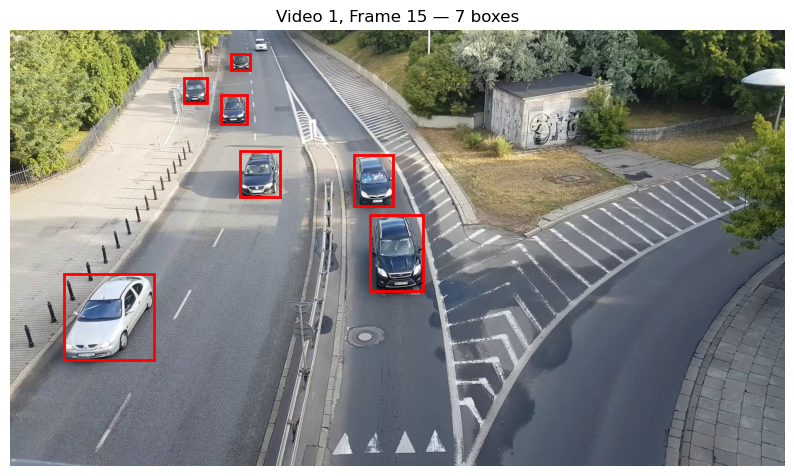

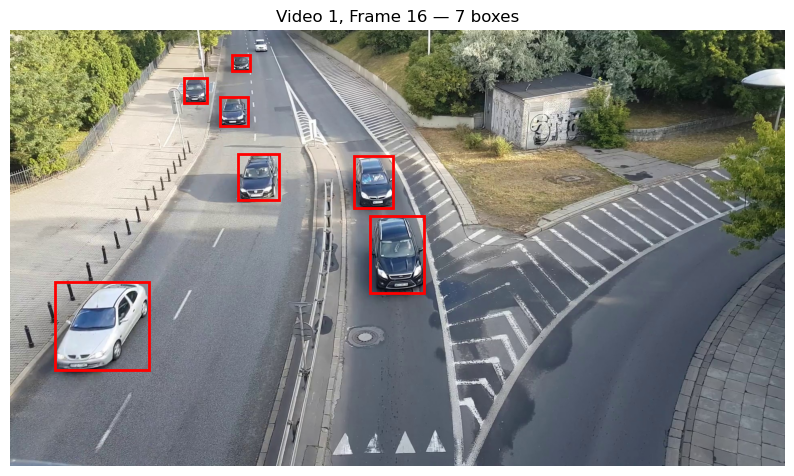

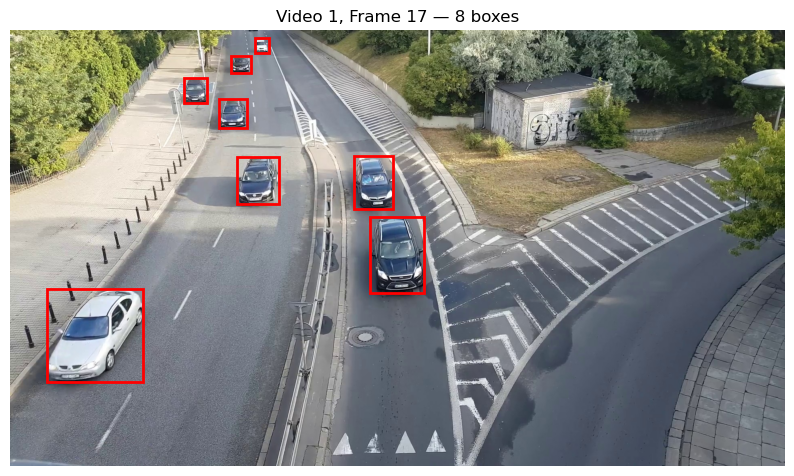

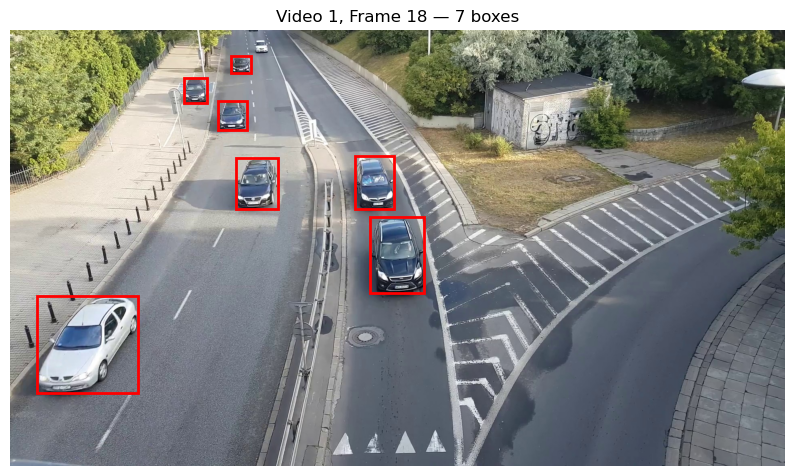

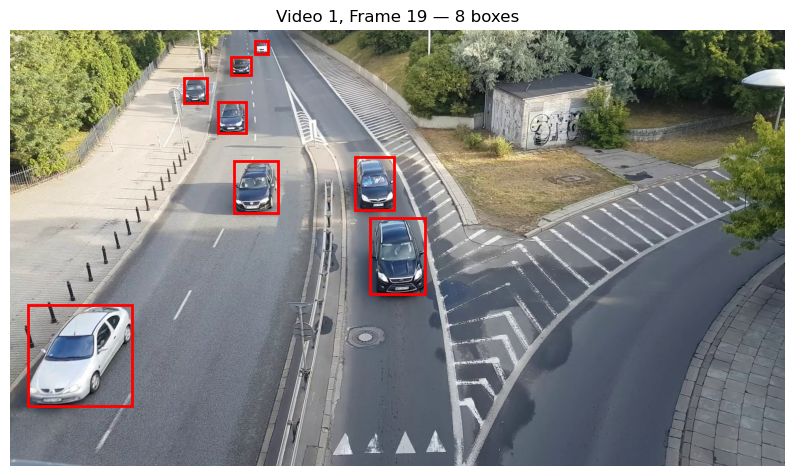

In [99]:
for _ in range(15, 20):
    visualize_detection(video_id=video_id, frame_idx=_)

## 2. Detection

In [11]:
def compute_center(box):
    x1, y1, x2, y2 = box
    return np.array([(x1 + x2) / 2, (y1 + y2) / 2])

In [12]:
def detect_anomalies(centers, alpha=0.2, k=5):
    distances = [np.linalg.norm(centers[i+1] - centers[i]) for i in range(len(centers)-1)]
    anomalies = []
    for i in range(k, len(distances) - k):
        neighbors = distances[i-k:i] + distances[i+1:i+k+1]
        avg = np.mean(neighbors)
        if abs(distances[i] - avg) > alpha * avg:
            anomalies.append(i)
    return anomalies

# 3. Ground Truth Simulation

In [13]:
def simulate_global_frame_missing(total_frames, drop_rate, seed = None):
    if seed is not None:
        np.random.seed(seed)
    all_frames = np.arange(total_frames)
    drop_num = int(total_frames * drop_rate)

    candidate_frames = list(all_frames[1:-1])
    np.random.shuffle(candidate_frames)

    dropped_frames = set()
    for f in candidate_frames:
        if (f - 1 in dropped_frames) or (f + 1 in dropped_frames):
            continue
        dropped_frames.add(f)
        if len(dropped_frames) >= drop_num:
            break

    kept_frames = [i for i in all_frames if i not in dropped_frames]

    print(f"[simulate] 丢帧总数: {len(dropped_frames)} / {total_frames} (目标: {drop_num})")
    return kept_frames, dropped_frames


In [14]:
def filter_trajectories(trajectories, kept_frames_set):
    new_trajectories = {}
    for tid, points in trajectories.items():
        filtered = [(f, b) for (f, b) in points if f in kept_frames_set]
        if len(filtered) > 1:
            new_trajectories[tid] = filtered
    return new_trajectories

# 4. Evaluation

In [15]:
def evaluate_detection(pred, gt, total):
    pred = set(pred)
    gt = set(gt)
    TP = len(pred & gt)
    FP = len(pred - gt)
    FN = len(gt - pred)
    TN = total - TP - FP - FN
    precision = TP / (TP + FP) if TP + FP > 0 else 0.0
    recall = TP / (TP + FN) if TP + FN > 0 else 0.0
    F1 = 2 * precision * recall / (precision + recall + 1e-16)
    return TP, FP, TN, FN, precision, recall, F1

# 5. Tracking

In [16]:
def track_objects(boxes_path, frames_dir):
    boxes_seq = np.load(boxes_path, allow_pickle=True)
    imgs = sorted(glob(os.path.join(frames_dir, '*.jpg')))
    trajectories = {}
    for i, (img_path, boxes) in enumerate(zip(imgs, boxes_seq)):
        image = cv2.imread(img_path)
        detections = np.array(boxes)
        if detections.shape[0] == 0:
            outputs = []
        else:
            bbox_xywh = []
            for box in detections:
                x1, y1, x2, y2 = box
                x = (x1 + x2) / 2
                y = (y1 + y2) / 2
                w = x2 - x1
                h = y2 - y1
                bbox_xywh.append([x, y, w, h])
            bbox_xywh = np.array(bbox_xywh)
            confidences = np.ones(len(bbox_xywh))
            classes = np.zeros(len(bbox_xywh))
            outputs, _ = deep_sort.update(bbox_xywh, confidences, classes, image)
            if outputs is not None and len(outputs) > 0:
                for output in outputs:
                    x1, y1, x2, y2, cls, track_id = output
                    bbox = [x1, y1, x2, y2]
                    if track_id not in trajectories:
                        trajectories[track_id] = []
                    trajectories[track_id].append((i, bbox))
    return trajectories, len(imgs)

# 6. Full Pipeline

In [17]:
def analyze_trajectories(trajectories, fps, alpha=0.3, k=5):
    anomalies_from_motion = set()
    centers_per_frame = defaultdict(dict)

    # 每帧的track中心
    for tid, points in trajectories.items():
        for f, bbox in points:
            centers_per_frame[f][tid] = compute_center(bbox)

    # 平均位移异常检测
    sorted_frames = sorted(centers_per_frame.keys())
    mean_shifts = []
    frame_pairs = []

    for i in range(1, len(sorted_frames)):
        f_prev = sorted_frames[i - 1]
        f_curr = sorted_frames[i]
        prev_dict = centers_per_frame[f_prev]
        curr_dict = centers_per_frame[f_curr]
        ts_prev = format_timestamp(f_prev, fps)
        ts_curr = format_timestamp(f_curr, fps)

        shared_ids = set(prev_dict.keys()) & set(curr_dict.keys())
        if len(shared_ids) == 0:
            print(f"[{ts_prev}->{ts_curr}] [SKIP] 帧对 ({f_prev}->{f_curr}) 没有共同目标")
            continue

        shifts = [
            np.linalg.norm(curr_dict[tid] - prev_dict[tid])
            for tid in shared_ids
        ]
        mean_shift = np.mean(shifts)
        print(f"[{ts_prev}->{ts_curr}] 帧对 ({f_prev}->{f_curr}) 平均移动距离 = {mean_shift:.2f}px 目标数={len(shared_ids)}")

        mean_shifts.append(mean_shift)
        frame_pairs.append(f_curr)

    # 滑动窗口动态检测平均位移跳变 
    for i in range(k, len(mean_shifts) - k):
        neighbors = mean_shifts[i - k:i] + mean_shifts[i + 1:i + k + 1]
        avg_neighbor = np.mean(neighbors)
        shift_i = mean_shifts[i]
        frame_i = frame_pairs[i]
        ts_i = format_timestamp(frame_i, fps)
        print(f"[{ts_i}] [COMPARE] 帧 {frame_i} 当前移动 {shift_i:.2f}, 周围均值 {avg_neighbor:.2f}", end=' ')
        if abs(shift_i - avg_neighbor) > alpha * avg_neighbor:
            print("❌异常")
            anomalies_from_motion.add(frame_i)
        else:
            print("✅正常")

    print(f"平均位移异常帧数: {len(anomalies_from_motion)}")
    print(f"检测到异常帧数: {sorted(anomalies_from_motion)}")

    return sorted(anomalies_from_motion)


# 7. Experiment

In [100]:
#参数配置
data_root = './videos'
save_dir = './boxes'
frames_dir = os.path.join(data_root, str(video_id).zfill(3))
boxes_path = os.path.join(save_dir, f'{video_id}.npy')

image_count = 0
for filename in os.listdir(frames_dir):
    if filename.lower().endswith('.jpg'):
        image_count += 1

seed = 20
drop_rate = 0.1
#gt模拟
kept_frames, dropped_frames = simulate_global_frame_missing(total_frames=image_count, drop_rate=drop_rate, seed = seed)

[simulate] 丢帧总数: 39 / 399 (目标: 39)


In [101]:
#构建多目标轨迹
trajectories, total_frames = track_objects(boxes_path, frames_dir)

#异常检测(gt模拟+评估)
filtered_trajs = filter_trajectories(trajectories, set(kept_frames))

In [126]:
alpha = 0.4
k = 5
anomalies_from_motion = analyze_trajectories(
    trajectories=filtered_trajs,
    fps=fps,
    alpha=alpha,
    k=k,
)


[0:00:00.000->0:00:00.033] 帧对 (0->1) 平均移动距离 = 8.27px 目标数=2
[0:00:00.033->0:00:00.067] 帧对 (1->2) 平均移动距离 = 2.12px 目标数=2
[0:00:00.067->0:00:00.100] 帧对 (2->3) 平均移动距离 = 4.42px 目标数=7
[0:00:00.100->0:00:00.133] 帧对 (3->4) 平均移动距离 = 4.54px 目标数=7
[0:00:00.133->0:00:00.166] 帧对 (4->5) 平均移动距离 = 5.01px 目标数=7
[0:00:00.166->0:00:00.200] 帧对 (5->6) 平均移动距离 = 4.32px 目标数=9
[0:00:00.200->0:00:00.233] 帧对 (6->7) 平均移动距离 = 4.60px 目标数=8
[0:00:00.233->0:00:00.299] 帧对 (7->9) 平均移动距离 = 8.82px 目标数=8
[0:00:00.299->0:00:00.333] 帧对 (9->10) 平均移动距离 = 5.22px 目标数=8
[0:00:00.333->0:00:00.399] 帧对 (10->12) 平均移动距离 = 10.27px 目标数=8
[0:00:00.399->0:00:00.432] 帧对 (12->13) 平均移动距离 = 5.54px 目标数=8
[0:00:00.432->0:00:00.499] 帧对 (13->15) 平均移动距离 = 10.30px 目标数=9
[0:00:00.499->0:00:00.532] 帧对 (15->16) 平均移动距离 = 6.81px 目标数=7
[0:00:00.532->0:00:00.566] 帧对 (16->17) 平均移动距离 = 6.80px 目标数=7
[0:00:00.566->0:00:00.632] 帧对 (17->19) 平均移动距离 = 12.86px 目标数=8
[0:00:00.632->0:00:00.665] 帧对 (19->20) 平均移动距离 = 6.81px 目标数=8
[0:00:00.665->0:00:00.699] 帧对 (20->21)

In [127]:
adjusted_gt = {f + 1 for f in dropped_frames if f + 1 < len(kept_frames) + len(dropped_frames)}
total_frames = len(kept_frames) + len(dropped_frames)

TP, FP, TN, FN, precision, recall, f1 = evaluate_detection(anomalies_from_motion, adjusted_gt, total_frames)

print("\n检测结果")
print(f"TP={TP}, FP={FP}, TN={TN}, FN={FN}")
print(f"Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")



检测结果
TP=35, FP=1, TN=359, FN=4
Precision=0.972, Recall=0.897, F1=0.933


In [128]:
print(sorted(adjusted_gt))

[9, 12, 15, 19, 36, 49, 58, 65, 96, 100, 111, 117, 133, 174, 187, 191, 198, 206, 211, 224, 230, 234, 237, 252, 258, 260, 263, 279, 281, 283, 289, 304, 309, 332, 348, 351, 356, 383, 393]
